In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# create directory for tensorboard logs
import os
if not os.path.exists('variance_constraint_mdmm_logs'):
    os.makedirs('variance_constraint_mdmm_logs')
    


In [3]:
# Bayesian Entropy Neural Network
# Define NN model
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.posterior_rho_init = -3.0
        self.prior_sigma_1 = 40.0
        self.prior_sigma_2 = 50.0
        self.blinear1 = BayesianLinear(input_dim, 4096, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(3.0).to(device = torch.device('cuda:0'))))
        self.blinear2 = BayesianLinear(4096, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),torch.tensor(3.0).to(device = torch.device('cuda:0'))))

    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.tanh(x_)
        x_ = self.blinear2(x_)
        return x_


Variance constraints - We need a distance aware variance constraint for the first demo.
For instance, we need to show that variance increases with distance from training data.


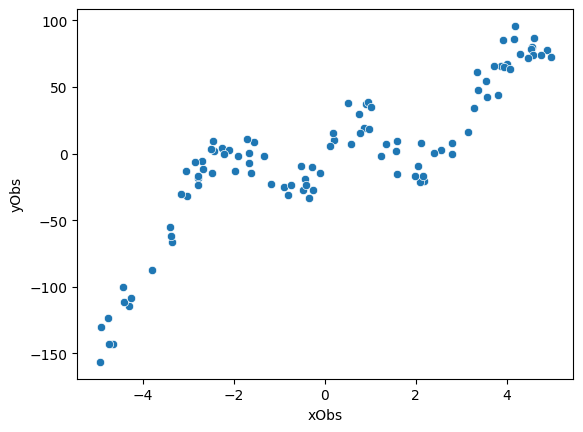

In [5]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
import pandas as pd
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

In [ ]:
# define a function that 